In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [8]:
df1 = pd.read_csv('sat.trn', sep=r'\s+', header=None)
df2 = pd.read_csv('sat.tst', sep=r'\s+', header=None)

In [9]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [10]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,80,102,102,79,76,102,102,79,76,102,...,87,79,107,109,87,79,107,113,87,3
1,76,102,102,79,76,102,106,83,76,102,...,87,79,107,113,87,79,103,104,83,3
2,80,98,106,79,76,94,102,76,76,94,...,79,79,95,100,79,79,95,96,75,4
3,76,94,102,76,76,94,102,76,76,94,...,79,79,95,96,75,79,95,100,75,4
4,76,94,102,76,76,94,102,76,76,89,...,75,79,95,100,75,75,95,100,79,4


In [16]:
df1.nunique()

0      50
1      81
2      74
3     101
4      49
5      81
6      74
7     100
8      50
9      80
10     77
11    102
12     49
13     82
14     75
15     98
16     49
17     79
18     72
19     99
20     50
21     79
22     75
23    101
24     50
25     82
26     74
27     97
28     50
29     80
30     76
31    101
32     49
33     79
34     77
35    104
36      6
dtype: int64

In [11]:
X1 = df1.iloc[:, :-1]  # Features
y1 = df1.iloc[:, -1]   # Labels

In [12]:
X2 = df2.iloc[:, :-1]  # Features
y2 = df2.iloc[:, -1]   # Labels

In [17]:
y1 = y1.astype(int)

In [19]:
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X1_scaled, y1, test_size=0.2, random_state=42, stratify=y1)

In [21]:

# 4. Initialize models
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy": DummyClassifier(strategy='prior', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42)
}

In [22]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append((name, acc, f1))

In [23]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Weighted F1-Score"])
print("\nBaseline Performance:")
print(results_df.sort_values(by="Weighted F1-Score", ascending=False))


Baseline Performance:
                 Model  Accuracy  Weighted F1-Score
0                  KNN  0.892897           0.891786
5                  SVM  0.880496           0.875131
3  Logistic Regression  0.853439           0.843937
1        Decision Tree  0.829763           0.828763
4          Naive Bayes  0.774521           0.783542
2                Dummy  0.241263           0.093788


In [24]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [25]:
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

In [26]:
roc_results = {}

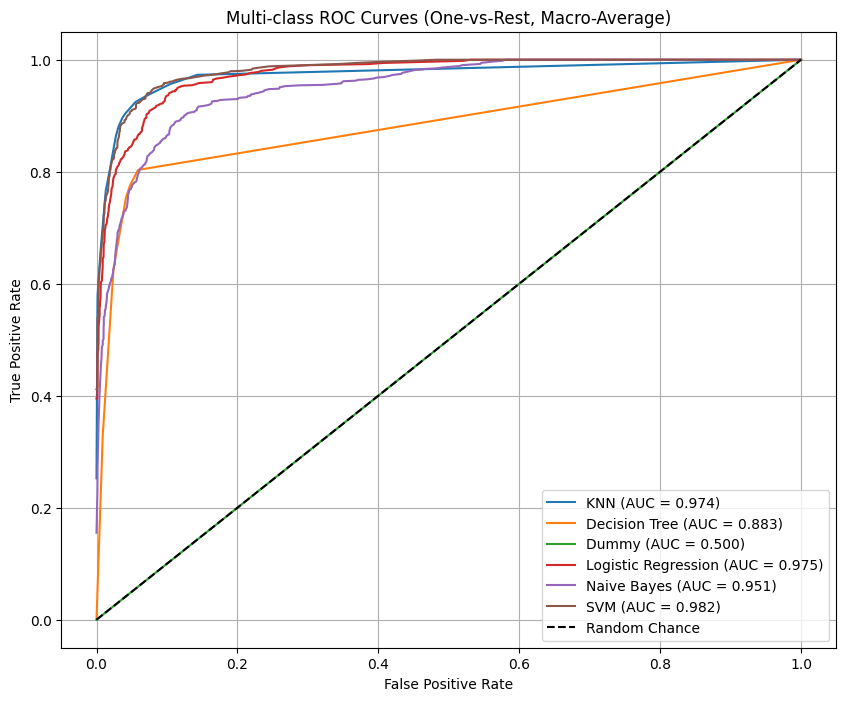

In [27]:
plt.figure(figsize=(10, 8))

for name, model in models.items():
    # Get probability estimates for each class
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        # For models without predict_proba (like plain SVM without probability=True)
        # but we already set probability=True for SVC
        continue

    # Compute ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)

    roc_results[name] = macro_auc

    plt.plot(all_fpr, mean_tpr, label=f"{name} (AUC = {macro_auc:.3f})")

# 3. Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curves (One-vs-Rest, Macro-Average)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [28]:
# 4. Display AUC summary
roc_df = pd.DataFrame(list(roc_results.items()), columns=["Model", "Macro-Averaged AUC"])
print("\nROC-AUC Results:")
print(roc_df.sort_values(by="Macro-Averaged AUC", ascending=False))


ROC-AUC Results:
                 Model  Macro-Averaged AUC
5                  SVM            0.981532
3  Logistic Regression            0.974711
0                  KNN            0.974162
4          Naive Bayes            0.951010
1        Decision Tree            0.882805
2                Dummy            0.500000


In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

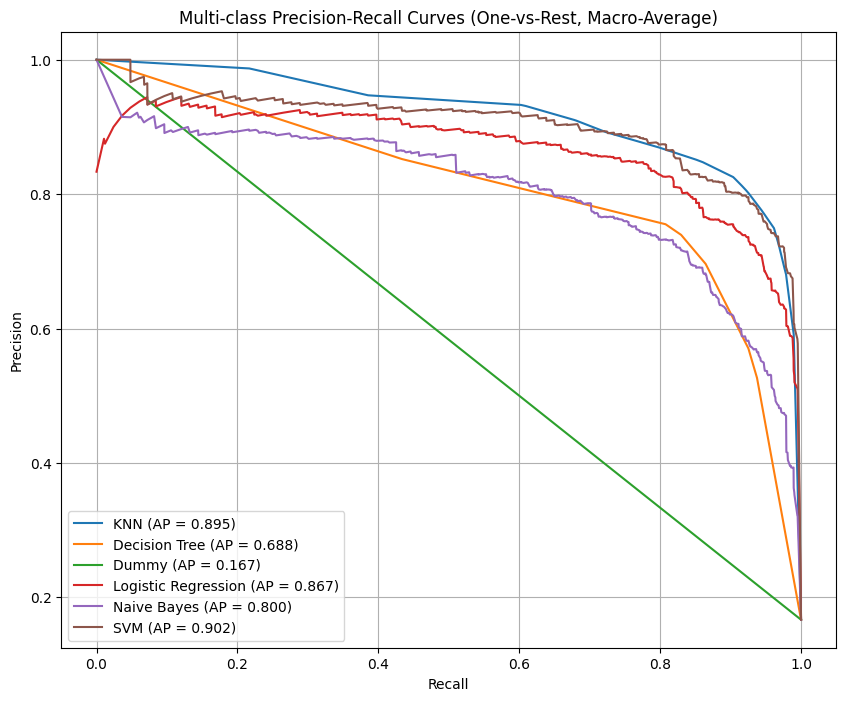

In [30]:
prc_results = {}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        continue  # skip if predict_proba not available

    precision = dict()
    recall = dict()
    avg_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        avg_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # Compute macro-average PRC
    all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
    mean_precision = np.zeros_like(all_recall)
    for i in range(n_classes):
        mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
    mean_precision /= n_classes

    macro_ap = np.mean(list(avg_precision.values()))
    prc_results[name] = macro_ap

    plt.plot(all_recall, mean_precision, label=f"{name} (AP = {macro_ap:.3f})")

# 2. Plot PRC curves
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curves (One-vs-Rest, Macro-Average)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [31]:


prc_df = pd.DataFrame(list(prc_results.items()), columns=["Model", "Macro-Averaged AP"])
print("\nPrecision-Recall (AP) Results:")
print(prc_df.sort_values(by="Macro-Averaged AP", ascending=False))



Precision-Recall (AP) Results:
                 Model  Macro-Averaged AP
5                  SVM           0.902264
0                  KNN           0.895150
3  Logistic Regression           0.867282
4          Naive Bayes           0.800114
1        Decision Tree           0.687812
2                Dummy           0.166667
